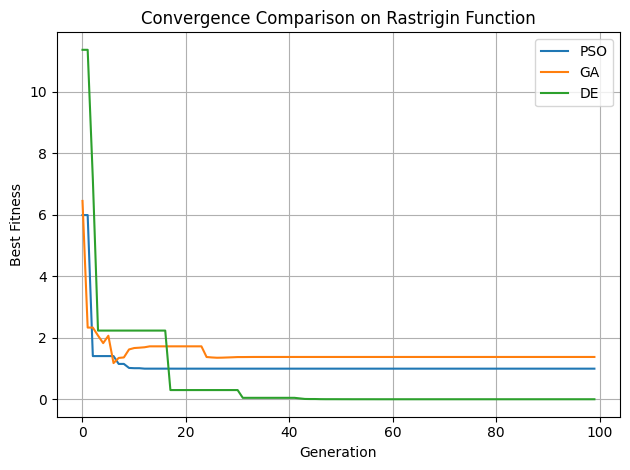

In [1]:
# Title: ASSIGNMENT TWO – METAHEURISTIC OPTIMIZATION OF THE TWO-DIMENSIONAL
# RASTRIGIN FUNCTION USING GA, PSO AND DE
# Student Name: Chao Meng
# Student ID: 100997810
# Date: Jul 22, 2025

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import random

# Define the Rastrigin function as the objective function for optimization.
# This function is multimodal and commonly used to evaluate optimization algorithms.
def rastrigin(X):
    x, y = X
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# Define the search space bounds for both variables (x and y).
bounds = [(-5.12, 5.12), (-5.12, 5.12)]

# ----------------------------
# Particle Swarm Optimization (PSO)
# ----------------------------
def run_pso(max_gen=100, swarm_size=30):
    # Initialize algorithm parameters
    w = 0.5   # Inertia weight
    c1 = 1.5  # Cognitive coefficient (individual)
    c2 = 1.5  # Social coefficient (group)
    dim = 2   # Problem dimensionality (x, y)

    # Initialize particle positions and velocities
    pos = np.random.uniform(-5.12, 5.12, (swarm_size, dim))
    vel = np.zeros_like(pos)

    # Initialize personal and global bests
    pbest = pos.copy()
    pbest_val = np.apply_along_axis(rastrigin, 1, pos)
    gbest = pbest[np.argmin(pbest_val)]
    gbest_val = min(pbest_val)

    history = []
     # Start the PSO main loop
    for gen in range(max_gen):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            vel[i] = w * vel[i] + c1 * r1 * (pbest[i] - pos[i]) + c2 * r2 * (gbest - pos[i])
            pos[i] += vel[i]
            pos[i] = np.clip(pos[i], -5.12, 5.12)
            val = rastrigin(pos[i])
            if val < pbest_val[i]:
                pbest[i] = pos[i]
                pbest_val[i] = val
        if min(pbest_val) < gbest_val:
            gbest = pbest[np.argmin(pbest_val)]
            gbest_val = min(pbest_val)
        history.append(gbest_val)
    # Save fitness history to CSV for later analysis
    pd.DataFrame(history, columns=["PSO_Fitness"]).to_csv("pso_fitness.csv", index_label="Generation")
    return history

# ----------------------------
# Genetic Algorithm （GA）
# ----------------------------
def run_ga(max_gen=100, pop_size=30, mutation_rate=0.1):
    # Define mutation function using Gaussian noise
    def mutate(x):
        return x + np.random.normal(0, 0.5, size=x.shape)

    # Define crossover function using linear combination
    def crossover(a, b):
        alpha = np.random.rand()
        return alpha * a + (1 - alpha) * b

    # Initialize the population with random individuals
    pop = np.random.uniform(-5.12, 5.12, (pop_size, 2))
    history = []

    # Start the GA main loop
    for gen in range(max_gen):
        fitness = np.apply_along_axis(rastrigin, 1, pop)
        # Select the top 50% of individuals
        selected = pop[np.argsort(fitness)[:pop_size // 2]]
        children = []

        # Perform crossover and mutation to generate new population
        while len(children) < pop_size:
            p1, p2 = random.choices(selected, k=2)
            child = crossover(p1, p2)
            if np.random.rand() < mutation_rate:
                child = mutate(child)
            child = np.clip(child, -5.12, 5.12)
            children.append(child)

        pop = np.array(children)
        best = rastrigin(pop[np.argmin(np.apply_along_axis(rastrigin, 1, pop))])
        history.append(best)

    # Save fitness history to CSV for later analysis
    pd.DataFrame(history, columns=["GA_Fitness"]).to_csv("ga_fitness.csv", index_label="Generation")
    return history

# ----------------------------
# Differential Evolution (DE) - Custom Implementation
# ----------------------------
def run_de(max_gen=100, pop_size=30, F=0.8, CR=0.9):
    dim = 2
    bounds = np.array([[-5.12, 5.12], [-5.12, 5.12]])

    # Initialize population randomly within the bounds
    pop = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(pop_size, dim))
    fitness = np.apply_along_axis(rastrigin, 1, pop)
    history = []

    # Start the DE main loop
    for gen in range(max_gen):
        for i in range(pop_size):

            # Select three distinct individuals for mutation
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

            # Create mutant vector
            mutant = np.clip(a + F * (b - c), bounds[:, 0], bounds[:, 1])

            # Perform crossover
            cross_points = np.random.rand(dim) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True
            trial = np.where(cross_points, mutant, pop[i])

            # Evaluate trial vector and select the better one
            f = rastrigin(trial)
            if f < fitness[i]:
                pop[i] = trial
                fitness[i] = f
        history.append(np.min(fitness))

    # Save fitness history to CSV for later analysis
    pd.DataFrame(history, columns=["DE_Fitness"]).to_csv("de_fitness.csv", index_label="Generation")
    return history

# ----------------------------------------------------------------
# Run all three algorithms and visualize their convergence behavior
# ----------------------------------------------------------------
pso_history = run_pso()
ga_history = run_ga()
de_history = run_de()

# Plot the convergence curve for each algorithm
plt.plot(pso_history, label="PSO")
plt.plot(ga_history, label="GA")
plt.plot(de_history, label="DE")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Comparison on Rastrigin Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("convergence_plot.png")
plt.show()

